# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_object_dtype

import math

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

import scipy
from scipy.cluster import hierarchy as hc

from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti

# Read Data

In [2]:
train_df = pd.read_csv(r'TrainAndValid.csv.zip')
test_df = pd.read_csv(r'Test.csv')

In [3]:
df = train_df.copy() # veri seti kopyalanir ve boylece orjinal veri bozulmaz

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

# Fix Missing

In [6]:
def fix_missing(df, col, name, nan_dict, is_train):
  if is_train: # eğer train setindeysen
    if is_numeric_dtype(col): # odaklanılan kolon numerik ise
      if pd.isnull(col).sum(): # odaklanılan kolonda null değerler varsa
        df[name+'_na'] = pd.isnull(col) # null verilerin olduğu kolonun adı + _na adında yeni bir kolon olusturup null olup olmama durumlarını true false olarak giriyoruz
        nan_dict[name] = col.median() # train setindeki null degerli kolonun medianını valid setinede aktarmak için yedekliyoruz
        df[name] = col.fillna(nan_dict[name]) # train setindeki null degerler yerine medianı giriyoruz
  else: # veri seti train degilde valid ise
    if is_numeric_dtype(col): # odaklanılan kolon numerik ise
      if name in nan_dict: # odaklanılan kolonun train seti verisinde null degerler bulunduysa odaklanılan kolonun name parametresinden gelen degeri nan_dict icinde vardır ve kosul saglanir
        df[name+'_na'] = pd.isnull(col) # valid setinde bos verilerin true false olarak yeni bir kolonda tutuyoruz
        df[name] = col.fillna(nan_dict[name]) # train setinden valid setine mantik aktarimi yapmak icin trainin o kolonunun medianini valid setindeki kolonun null degerleri yerine giriyoruz
      else: # valid veri setinde null degerler var fakat train setinde yoksa bu kosul saglanır
        df[name] = col.fillna(df[name].median()) # valid setindeki ilgili kolonun mediani null degerler yerine girilir

# proc_df

In [7]:
def proc_df(df, y_fld, nan_dict=None, is_train=True, max_cat=None):
    df = df.copy()
    y = df[y_fld].values # bagimli degiskeni aliyoruz
    df.drop(y_fld, axis=1, inplace=True) # modele hazir hale getirmek icin y kolonunu veri setinden siliyoruz

    if nan_dict is None: # fix_missing fonksiyonundaki trainden valide mantik aktarimi yapmak icin medianlari burada biriktiriyoruz
        nan_dict = {} # eger ilgili veri seti train ise onceden fix_missing'ten gelmis olan nan_dict degerleri temizliyor

    for n, c in df.items(): # df kolonlarinda dolas, n: kolon ismi, c: kolon verisi
        fix_missing(df, c, n, nan_dict, is_train) # donguden gelen kolon icinde null degeleri median ile degistir
        numericalize(df, c, n, max_cat) # metinsel verileri numerik verilere donustur

    df = pd.get_dummies(df, dummy_na=True)
    if is_train: # odaklanılan veri seti train ise valide mantik aktarimi icin nan_dict (train null kolonlarin medianlari) verileri return yap
        return df, y, nan_dict

    return df, y # odaklanilan veri seti valid ise nan_dict return yapma sadece df ve y verilerini don

# Categorical to Numeric

Random Forest'ta modelimiz split yaparken local optimuma göre çalışır. Yani ilk splitteki ağaç daha iyi sonuç vermesede oraya gider. Fakat One-Hot Encoding'te o kolondaki tüm unique değerler 1 ve 0 diye kodlandığı için mutlaka splitte bakılır ve önemli bir feature varsa o kolona göre o bilgiyi kaçırmamış oluruz.

Eğer çok fazla unique değer varsa o kolonun model için önemli olduğunu düşünüyorsak deneyipsonucumuza iyi gelip gelmediğine bakmalıyız. Fakat tüm veri ile değilde subsamplelar ile çabucak deneyip görmek daha efektif olacaktır.

Aşağıdaki if koşulunda (len(col.cat.categories) > max_cat) ile makimum unique değer olarak belirlediğimiz değerden büyükse klasik 1,2,3 diye cat dönüşümü yap diyoruz. 

In [8]:
def numericalize(df, col, name, max_cat):
    if not is_numeric_dtype(col) and (max_cat is None or len(col.astype('category').cat.categories) > max_cat):
        # df[name] = col.astype('category').cat.codes + 1
        df[name] = pd.Categorical(col).codes + 1

# Fill Wrong YearMade

In [9]:
print('before : ', df.loc[df['YearMade'] < 1900, 'YearMade'].count())

df.loc[df['YearMade'] < 1900, 'YearMade'] = df.loc[df['YearMade'] > 1900]['YearMade'].mean()

print('after : ', df.loc[df['YearMade'] < 1900, 'YearMade'].count())

before :  39391
after :  0


# Datetime to Numeric

In [10]:
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')

In [11]:
def add_datepart(df, dt_name, drop=True):
    dt_column = df[dt_name]
    column_dtype = dt_column.dtype
    
    attr = ['year', 'month', 'week', 'day', 'dayofweek', 'dayofyear', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start']
    
    for a in attr:
        if a == 'week':
            df['Date' + a.capitalize()] = getattr(dt_column.dt.isocalendar(), a)
            print('Date' + a.capitalize() + ' created.')
        else:
            df['Date' + a.capitalize()] = getattr(dt_column.dt, a)
            print('Date' + a.capitalize() + ' created.')
        
    df['Date' + 'Elapsed'] = dt_column.astype(np.int64)
    
    if drop:
        df.drop(dt_name, axis=1, inplace=True)
        print(dt_name + ' deleted.')
    
    print('Datepart done!')

In [12]:
add_datepart(df, 'saledate')

DateYear created.
DateMonth created.
DateWeek created.
DateDay created.
DateDayofweek created.
DateDayofyear created.
DateIs_month_end created.
DateIs_month_start created.
DateIs_quarter_end created.
DateIs_quarter_start created.
DateIs_year_end created.
DateIs_year_start created.
saledate deleted.
Datepart done!


# RMSLE

RMSE gerçek değerden miktarsal olarak ne kadar farklı olduğunun sonucunu verirken, RMSLE relative erroru verir.
Amaç hatanın miktarı değil relative olarak gerçek miktara oranla nasıl konumlandığını bulmaktır.
Aynı oranda hatayı aynı miktarda modele hissettirir.
RMSLE outlinerları normalize eder. Çok büyük sayıların logaritmasını aldığımızda daha normalize etmiş oluruz.
RMSLE under estimationu cezalandırır. Pizzanın erken gelmesini geç gelmesinden daha fazla cezalandırır.
Modeli çalıştırmadan önce y'nin logaritmasını yukarıdaki gibi alırsak hatamızda RMSLE olmuş olur.

In [13]:
print('before : \n\n', df['SalePrice'])
df['SalePrice'] = np.log(df.SalePrice)
print('-'*50)
print('after : \n\n', df['SalePrice'])

before : 

 0         66000.0
1         57000.0
2         10000.0
3         38500.0
4         11000.0
           ...   
412693    10000.0
412694    10500.0
412695    12500.0
412696    10000.0
412697    13000.0
Name: SalePrice, Length: 412698, dtype: float64
--------------------------------------------------
after : 

 0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259131
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 412698, dtype: float64


# split_train_val

In [14]:
def split_train_val(df, n):
  return df[:n].copy(), df[n:].copy()

In [15]:
raw_train, raw_y, nas = proc_df(df, 'SalePrice', max_cat=7)

n_valid = 41000 # Toplam train veri setinin yaklaşık %10 u kadarını validation için ayırıyoruz.
n_train = len(df) - n_valid

x_train, x_valid = split_train_val(raw_train, n_train)
y_train, y_valid = split_train_val(raw_y, n_train)

In [16]:
df.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((412698, 65), (371698, 173), (371698,), (41000, 173), (41000,))

# rmse

In [17]:
def rmse(x, y):
  return math.sqrt(((x-y)**2).mean())

# print_score

In [18]:
def print_score(m, x_train, y_train, x_valid, y_valid):
  print(f'RMSE of train set {rmse(m.predict(x_train), y_train)}')
  print(f'RMSE of valid set {rmse(m.predict(x_valid), y_valid)}')
  print(f'R^2 of train set {m.score(x_train, y_train)}')
  print(f'R^2 of valid set {m.score(x_valid, y_valid)}')
  if hasattr(m, 'oob_score_'):
    print(f'OOB Score : {m.oob_score_}')
  print(20*'-')

# Base Model

In [19]:
m = RandomForestRegressor(n_jobs = -1,
                          oob_score = True,
                          random_state=50)

%time m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_valid, y_valid)

CPU times: total: 26min 4s
Wall time: 7min 53s
RMSE of train set 0.07598117439800255
RMSE of valid set 0.257279020099539
R^2 of train set 0.9878913865160298
R^2 of valid set 0.8773467062077137
OOB Score : 0.9118633487258924
--------------------


# Subsample

In [20]:
def get_sample(df, n): # n: eleman sayisi
  idxs = np.random.permutation(len(df))[:n] # df in uzunlugu kadar sayiyi random yeniden sırala ve sıfırdan n. elemana kadar olanı idxs icine at
  return idxs, df.iloc[idxs].copy() # iloc ile random yaratilan indexleri kullanarak df icinden random satir cek

In [21]:
idxs, x_sample = get_sample(x_train, 5000) # x_train icinden x adet random satir cektik
y_sample = y_train[idxs] # cekilen satirlarin indexlerini idxs degiskeninde tuttugumuz icin random x lerin y lerinide cekebildik

In [22]:
x_sample.shape, y_sample.shape, x_valid.shape, y_valid.shape

((5000, 173), (5000,), (41000, 173), (41000,))

# get_sample_check

In [23]:
def get_sample_check(df, sample_size, loop, score=False):
    m_sub1_2 = RandomForestRegressor(max_features = 0.5, # grid_search.best_params_['max_features'],
                                     min_samples_leaf = 3,
                                     n_estimators = 40, # grid_search.best_params_['n_estimators'],
                                     n_jobs = -1,
                                     oob_score = True,
                                     random_state=50)
    
    for i in range(loop):
        idxs, x_sample1_2 = get_sample(df, sample_size)
        y_sample1_2 = y_train[idxs]
        m_sub1_2.fit(x_sample1_2, y_sample1_2)
        
        if score=='oob': return m_sub1_2.oob_score_
            
        if score: print_score(m_sub1_2, x_sample1_2, y_sample1_2, x_valid, y_valid)
        else: print(f'R^2 of train set {m_sub1_2.score(x_sample1_2, y_sample1_2)}\n', '-'*30)

    return m_sub1_2

In [24]:
get_sample_check(x_train, 4000, 4, score=True)

RMSE of train set 0.17623910932648265
RMSE of valid set 0.36046183659578446
R^2 of train set 0.9354955070092331
R^2 of valid set 0.7592373849248886
OOB Score : 0.7820375662655701
--------------------
RMSE of train set 0.17466503835745825
RMSE of valid set 0.36809681993510857
R^2 of train set 0.9347931211546777
R^2 of valid set 0.7489301283732566
OOB Score : 0.777374536515291
--------------------
RMSE of train set 0.17924540009618575
RMSE of valid set 0.3589615982844749
R^2 of train set 0.932202302828909
R^2 of valid set 0.7612373172589062
OOB Score : 0.7700664864892084
--------------------
RMSE of train set 0.18153636082073205
RMSE of valid set 0.35634736539656914
R^2 of train set 0.9315824426925429
R^2 of valid set 0.7647023585221314
OOB Score : 0.7663856288692199
--------------------


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True, random_state=50)

# GridSearchCV

In [25]:
params = {'max_depth': [5, 6, 7, 8],
         'max_features': [5, 7, 9, 11],
         'n_estimators': [100, 200, 300, 400]}
# grid_search = GridSearchCV(m, params, n_jobs=-1, verbose=2)
# grid_search.fit(x_train, y_train)

# {'max_depth': 8, 'max_features': 11, 'n_estimators': 100}

In [26]:
# print(grid_search.best_params_)
# print(grid_search.best_score_)

# {'max_depth': 8, 'max_features': 11, 'n_estimators': 100}
# 0.6298418688473115

# Final Model

In [27]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((371698, 173), (371698,), (41000, 173), (41000,))

In [28]:
final_model = RandomForestRegressor(# max_depth = 8, # grid_search.best_params_['max_depth'],
                                    max_features = 0.5, # grid_search.best_params_['max_features'],
                                    min_samples_leaf = 3,
                                    n_estimators = 40, # grid_search.best_params_['n_estimators'],
                                    n_jobs = -1,
                                    oob_score = True,
                                    random_state=50)

%time final_model.fit(x_train, y_train)
print_score(final_model, x_train, y_train, x_valid, y_valid)

CPU times: user 4min 13s, sys: 1.41 s, total: 4min 14s
Wall time: 1min 9s
RMSE of train set 0.11998043050207616
RMSE of valid set 0.24772743346225296
R^2 of train set 0.9698072101383588
R^2 of valid set 0.8862847590288987
OOB Score : 0.910167667182496
--------------------


# set_rf_samples

In [ ]:
# Changes Scikit Learn's random forests to give each tree a random sample of n random rows.
def set_rf_samples(n_trees):
  _forest._generate_sample_indices = (lambda self, rs, n_samples_bootstrap: _forest.check_random_state(rs).randint(0, n_samples_bootstrap, n_trees))

# Undoes the changes produced by set_rf_samples.
def reset_rf_samples():
  _forest._generate_sample_indices = (lambda self, rs, n_samples_bootstrap: _forest.check_random_state(rs).randint(0, n_samples_bootstrap, n_samples_bootstrap))

In [ ]:
# set_rf_samples(20000)

In [ ]:
# reset_rf_samples()

# Feature Importance

Modelimizi eğittikten sonra hangi kolondaki değerler modelimiz için daha önemli sorusuna cevap arıyoruz. Bunun için eğittiğimiz modeli tekrar çalıştırmadan önce sırayla tüm kolonlardaki verileri teker teker karıştırıyoruz, sonra modeli çalıştırıp R^2 değerine bakıyoruz. Buradaki düşüş oranına göre bu kolon bizim için şu önemde diyerek bir sıralama yapıyoruz.

m.feature_importances_ >> Kolonların önemini sayısal olarak verir. Bir model objectidir.

In [29]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'columns': df.columns, 'importance': m.feature_importances_},).sort_values('importance', ascending=False)

In [30]:
feature_importance = rf_feat_importance(final_model, x_train);

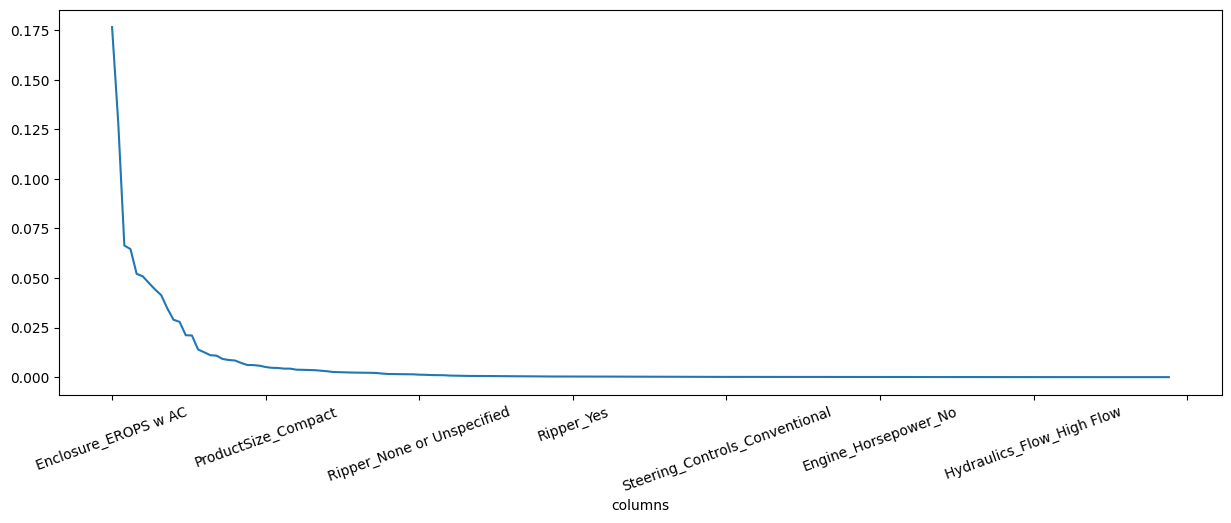

In [31]:
feature_importance.plot('columns', 'importance', figsize=(15,5), legend=False, fontsize=10, rot=20);

In [32]:
def plot_feature_importance(fi):
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False, rot=0)

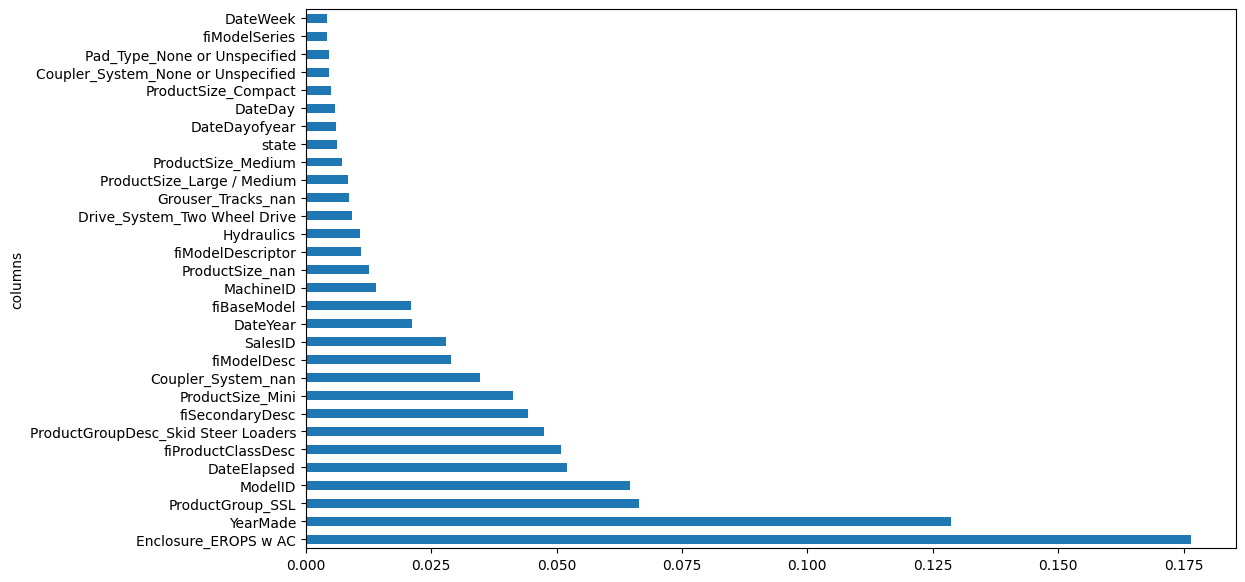

In [33]:
plot_feature_importance(feature_importance[:30]);

Model ne kadar sade olursa o kadar doğru sonuç üretir. Feature sayısının çok olması modelin aslında olmayan bir patterni üretmesine sebep olabilir.
Kısaca; Ne kadar az feature, o kadar az yanlış pattern olasılığı.

In [34]:
# Select the most important ones

keep_columns = feature_importance[feature_importance['importance'] > 0.005]['columns']

# 173 featuredan 26'a düşüldü !

In [35]:
len(feature_importance), len(keep_columns)

(173, 26)

In [36]:
raw_train.shape, raw_y.shape

((412698, 173), (412698,))

In [37]:
df_keep = raw_train[keep_columns].copy()

n_valid = 41000
n_train = len(df) - n_valid

x_train, x_valid = split_train_val(df_keep, n_train)
y_train, y_valid = split_train_val(raw_y, n_train)

In [38]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((371698, 26), (371698,), (41000, 26), (41000,))

In [39]:
%time final_model.fit(x_train, y_train)
print_score(final_model, x_train, y_train, x_valid, y_valid)

CPU times: user 2min 1s, sys: 404 ms, total: 2min 1s
Wall time: 33.1 s
RMSE of train set 0.1258783575051254
RMSE of valid set 0.2520581409311368
R^2 of train set 0.9667658521533085
R^2 of valid set 0.8822741249926159
OOB Score : 0.9076408127269843
--------------------


Featureları atmadan önceki R^2 skoru ile kıyaslama yapılmalı! Aşağıdaki grafikte tekrar çizidiğimizde öenm sıralarının değiştiğini göreceğiz. Çünkü silinen featurelar alt splitlerde kullanılıyordu, fakat silinince üst feature'unun önemi değiştirmiş olduk.

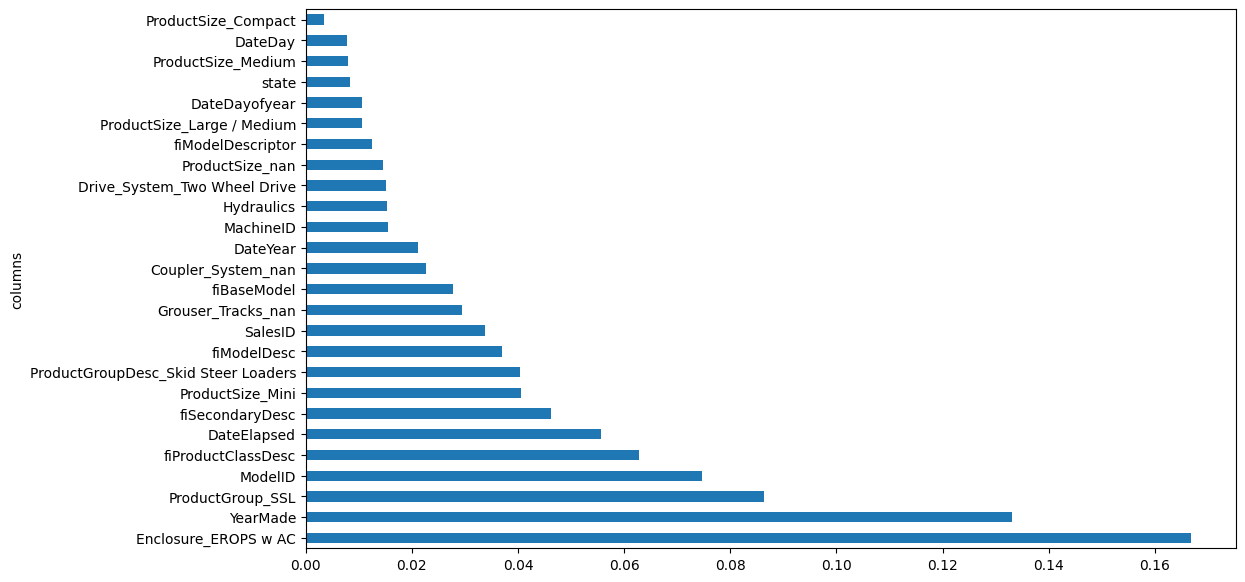

In [40]:
feature_importance = rf_feat_importance(final_model, df_keep)
plot_feature_importance(feature_importance);

# Confidence Based on Tree Variance

Ağaç varyansına dayalı güveni hesaplayacağız. Modelimiz bir şeyleri tahmin ediyor, fakat tahmin ettiği şeylerde kendine ne kadar güveniyor? sorusuna cevap arıyoruz.

Araba satışını tahmin ederken araba rengi kırmızıyken mi yoksa maviyken mi dahadoğru tahminde bulunuyoruz? Belki modelimiz kırmızı arabaları daha iyi tahmin ediyor.. Peki bunu nasıl ölçeriz?

Eğer bir feature değeri az görülüyorsa ağaçta daha az dallanmalara neden olacaktır. Çünkü daha az split yapacaktır. Az görülen bu değerler bir pattern oluşturmayacağı için random dağılacaktır ve bu değerlerin standart sapması yüksek olacaktır.

Bundan yola çıkarak; modelimize bu nadir görülen ve standart sapması yüksek olan featurelerle kurulan modellere ve sonuçlara daha az güven diyebileceğiz!

Hadi başlayalım!

In [41]:
%time preds = np.array([t.predict(x_valid) for t in final_model.estimators_]) # final_model_w_fi.estimators_ treelerin olduğu değişken

# Modelimizden ağaçları tek tek alaacağız ve onların tahminlerinin standart sapmasını bulacağız.

np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 520 ms, sys: 4.99 ms, total: 525 ms
Wall time: 526 ms


(9.648672675557028, 0.17516006498221356)

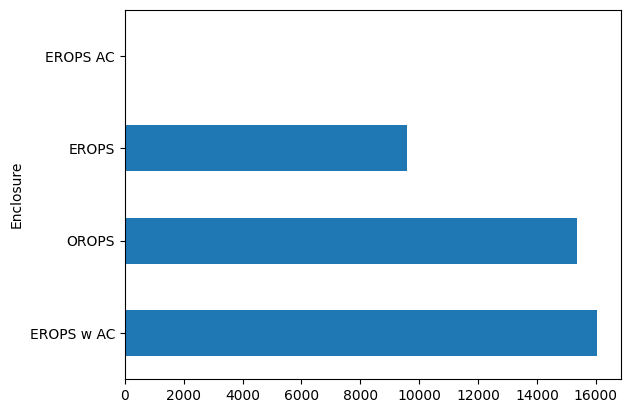

In [42]:
X = df[n_train:].copy()
# En raw halini df'den aldık çünkü one-hot encoding, feature importance ve datetime to numeric ile verinin bu işleme özel istediğimiz yapısını kaybediyoruz.
# Bu konudan sonra final modelimiz yukarıdaki iyileştirmeler eklenerek devam edilecektir.

X['pred_std'] = np.std(preds, axis=0) # Std of our predictions
X['pred'] = np.mean(preds, axis=0) # Our predictions

# X['YearMade'][:10].value_counts().plot.barh();
X['Enclosure'].value_counts().plot.barh();
# Enclosure'ın önemli bir feature olduğunu biliyoruz.
# Hangi unique değerden kaç tane var? Bunu çiziyoruz.

In [43]:
preds[:,0].shape

(40,)

In [44]:
fields = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enclosure_table = X[fields].groupby('Enclosure', as_index=True).mean()
enclosure_table

,SalePrice,pred,pred_std
Enclosure,,,
EROPS,9.904188,9.881154,0.260656
EROPS AC,9.466425,9.527123,0.328549
EROPS w AC,10.610471,10.611774,0.229538
OROPS,9.719124,9.743495,0.219416


In [45]:
df['ProductSize'].value_counts()

ProductSize
Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: count, dtype: int64

<Axes: ylabel='ProductSize'>

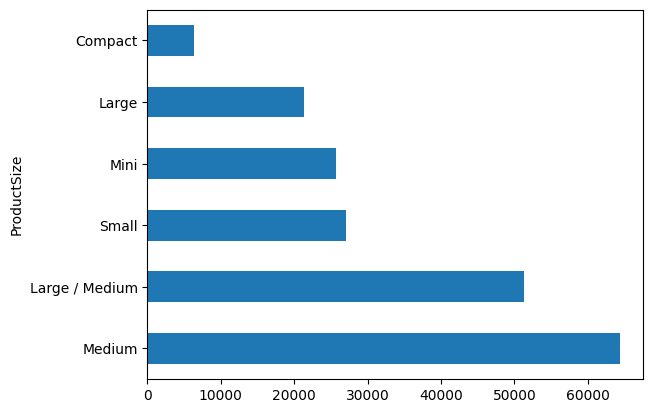

In [46]:
df['ProductSize'].value_counts().plot.barh()

In [47]:
fields = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
size_table = X[fields].groupby('ProductSize', as_index=True).mean()
size_table

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.524607,9.670343,0.251340
Large,10.542199,10.480465,0.316302
Large / Medium,10.680092,10.653611,0.261527
Medium,10.666512,10.656174,0.239698
Mini,9.586820,9.604649,0.221836
Small,10.341143,10.347286,0.277339


In [48]:
# Önemli olan std sapmanın büyüklüğü değildir. Prede oranla ne kadar büyük olduğu önemlidir !! Onun için std sapmayı predlere bölüyoruz. Bu bize gerçek sapmayı verir.

(size_table['pred_std'] / size_table['pred']).sort_values(ascending=False)

# Large degeri diğerlerinden daha büyük bir sapma yaptığı için Large için bulunan predler daha az güvenilir denilebilir. Çünkü bunlar en az bulunanlardır.

ProductSize
Large             0.030180
Small             0.026803
Compact           0.025991
Large / Medium    0.024548
Mini              0.023097
Medium            0.022494
dtype: float64

# Removing Redundant Features

Gereksiz özelliklerin kaldırılmasıdır.

Öncelikle bir dendogram çizdiririz. Dendrogram; hiyerarşik kümeleme (Hangilerinin benzer olduğunu bulmak için kullanacağız.)

Bazı değişkenler benzer anlamlara sahipse, özelliğin önemini yorumlamak daha zordur ve yanlış şablon tanımariskini arttırabilir. Bu nedenle bunları kaldırmaya çalışacağız ve doğrulun azalıp azalmadığını kontrol edeceğiz.

Pearson lineer olmayan ilişkilerde bağlantı yok diyebilir. Spearman non-linear olanlarında ilişkisini veriyor. Spearman bunu rank correlation ile yapar.

In [49]:
scipy.stats.spearmanr(x_train).correlation

array([[ 1.00000000e+00,  2.74767069e-01, -1.51400266e-01,
        -6.58621458e-02,  2.42315792e-01,  6.83517427e-02,
        -1.51400266e-01,  8.36157842e-02, -6.70754543e-02,
         1.51331316e-01,  5.15512891e-02,  6.78685052e-02,
         2.42526870e-01,  4.91663254e-02, -1.42918873e-01,
        -2.43306346e-01,  2.19014000e-01,  1.32902885e-01,
        -1.45767034e-01,  1.51363188e-01,  2.09885381e-01,
         1.33474090e-01, -3.95817964e-02, -1.36542620e-02,
         4.20481452e-03, -3.54728966e-02],
       [ 2.74767069e-01,  1.00000000e+00,  2.04437847e-01,
         9.51183658e-02,  6.13920385e-01, -1.73510397e-01,
         2.04437847e-01,  1.41437288e-01,  1.24016690e-01,
        -2.04607735e-01, -5.14792575e-02,  2.51038103e-01,
         6.13983470e-01, -5.77977074e-02, -8.99716516e-02,
         5.90783088e-02,  2.27862100e-01,  6.93431072e-02,
        -4.42638630e-02, -2.04864850e-01,  6.95384733e-02,
        -9.96123993e-02, -5.46933937e-02, -1.06196837e-02,
         2.21

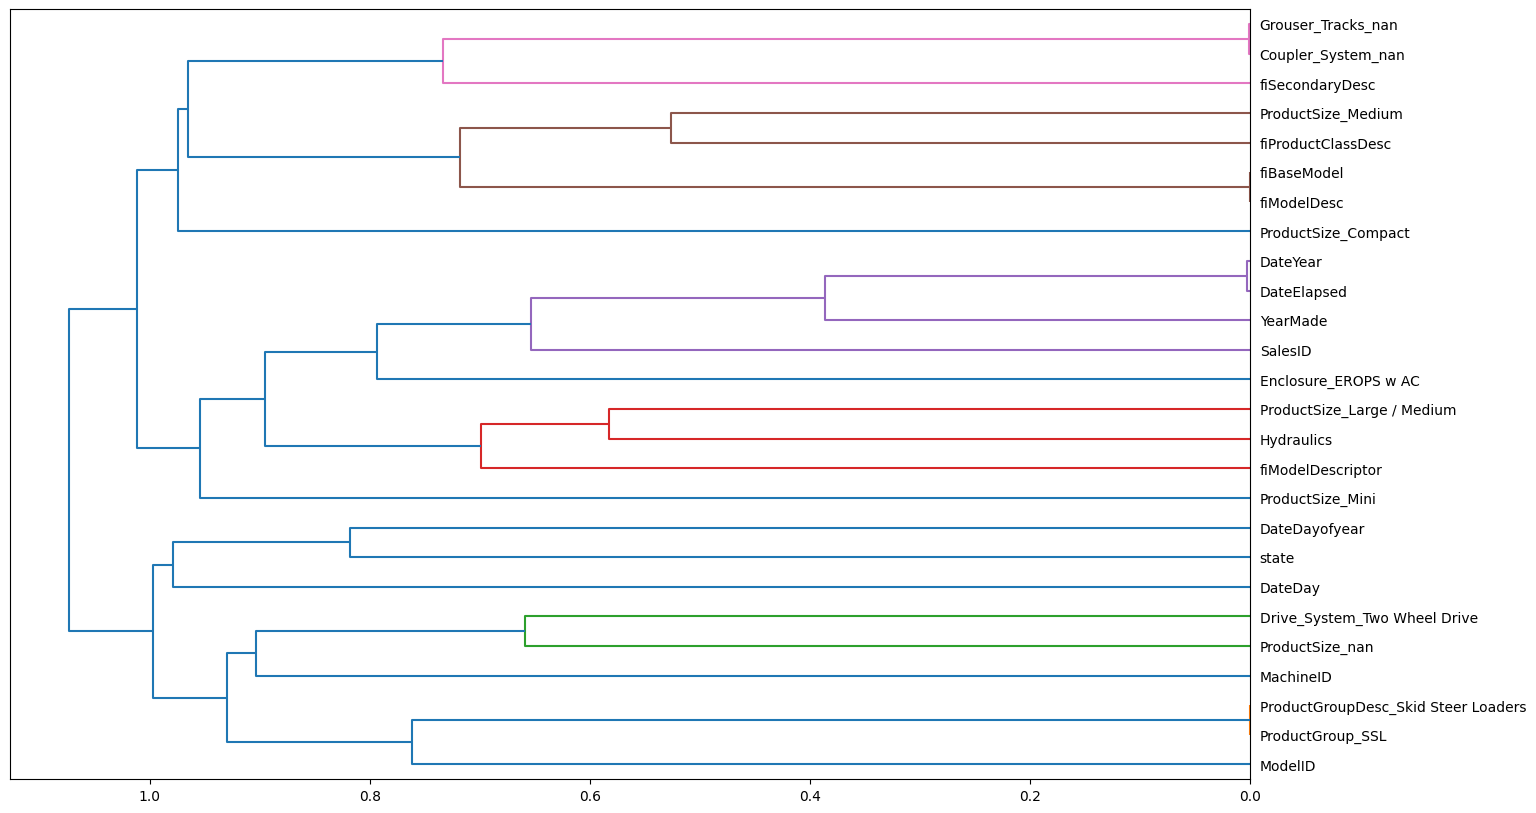

In [50]:
corr = np.round(scipy.stats.spearmanr(x_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=x_train.columns, orientation='left', leaf_font_size=10)
plt.show()
# Benzer özellikleri kaldırmaya çalışacağız ve doğruluğumuzu etkileyip etkilemediğini göreceğiz.

In [51]:
# Aşağıdaki get_oob fonksiyonu ile de kıyaslama yapılabilir, fakat bu çalışmada get_sample_check fonksiyonu ile oob skoru kıyaslamasını yapacağız.
def get_oob(df):
    m = RandomForestRegressor(
    # max_depth = 8, # grid_search.best_params_['max_depth'],
    max_features = 0.5, # grid_search.best_params_['max_features'],
    min_samples_leaf = 3,
    n_estimators = 40, # grid_search.best_params_['n_estimators'],
    n_jobs = -1,
    oob_score = True,
    random_state=50)

    x, _ = split_train_val(raw_train, 1000)
    y, _ = split_train_val(raw_y, 1000)
    
    %time m.fit(x_train, y_train)
    return m.oob_score_

OOB Score nedir?

Random Forest , decision trees gibi modellerin prediction hatasını hesaplamak için kullanılır. Çalışma prensibi olarak kısaca; o veriyi görmeyenlerin ortalamasını alır diyebiliriz. Yani eğer validation skora bakmış olsaydık 10 ağacımız varsa onunun ortalamasını alacaktı, fakat OOB scoreda o veriyi görmeyen 3 tane ağacımız varsa OOB score o 3 ağacın ortalamasını alır.

In [52]:
# Here's our baseline.
# get_oob(x_train)
get_sample_check(x_train, 4000, 5, score='True')

RMSE of train set 0.18075091812542876
RMSE of valid set 0.3452141277727155
R^2 of train set 0.9302817077854135
R^2 of valid set 0.7791753295209419
OOB Score : 0.7770600372045553
--------------------
RMSE of train set 0.1811369106723858
RMSE of valid set 0.3628248004578529
R^2 of train set 0.9289430902333711
R^2 of valid set 0.7560704583763254
OOB Score : 0.7745757867252729
--------------------
RMSE of train set 0.1826829608954206
RMSE of valid set 0.35231528308538557
R^2 of train set 0.9297634466571275
R^2 of valid set 0.7699970346745908
OOB Score : 0.7773590876573145
--------------------
RMSE of train set 0.1832449652141268
RMSE of valid set 0.35880934046322244
R^2 of train set 0.9320479135468994
R^2 of valid set 0.7614398223522815
OOB Score : 0.7814595211551777
--------------------
RMSE of train set 0.18160309280564246
RMSE of valid set 0.3511404109859336
R^2 of train set 0.9333387669677635
R^2 of valid set 0.7715284669977429
OOB Score : 0.7868439798389611
--------------------


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True, random_state=50)

Eğer attığımız featurelar sonucu model kötüye gitmiyorsa onları atacağız ve fazla featuredan kurtulmuş olacağız.

In [53]:
for col_name in ('Grouser_Tracks_nan',
                'Coupler_System_nan',
                'fiBaseModel',
                'fiModelDesc',
                'DateYear',
                'DateElapsed',
                'ProductGroupDesc_Skid Steer Loaders',
                'ProductGroup_SSL'
                ):
    #print(col_name, get_oob(x_train.drop(col_name, axis=1)))
    for i in range(5):
        checker = get_sample_check(x_train.drop((col_name), axis=1), 4000, 1, score='oob')
        if(checker < 0.77): print(checker, ' >> ', col_name, '(silinebilir)')
        else: print(checker, ' >> ', col_name)
    print('-'*60)

0.7769558266074253  >>  Grouser_Tracks_nan
0.7850544963061803  >>  Grouser_Tracks_nan
0.7831628580591138  >>  Grouser_Tracks_nan
0.781142054462763  >>  Grouser_Tracks_nan
0.7849065723387227  >>  Grouser_Tracks_nan
------------------------------------------------------------
0.7841192703753298  >>  Coupler_System_nan
0.7814209168140459  >>  Coupler_System_nan
0.7706401267528212  >>  Coupler_System_nan
0.776263026007155  >>  Coupler_System_nan
0.7849650948025526  >>  Coupler_System_nan
------------------------------------------------------------
0.7923863730539084  >>  fiBaseModel
0.7641401952584679  >>  fiBaseModel (silinebilir)
0.7827887256039535  >>  fiBaseModel
0.7893769903024594  >>  fiBaseModel
0.7848215628695738  >>  fiBaseModel
------------------------------------------------------------
0.7712132982222631  >>  fiModelDesc
0.7911969576698832  >>  fiModelDesc
0.7650038744444922  >>  fiModelDesc (silinebilir)
0.7840272535079252  >>  fiModelDesc
0.7832170234079496  >>  fiModelDesc
-

In [54]:
# Her benzer feature'dan birini silmeyi deniyoruz.
deleted_features = ['fiBaseModel', 'DateYear', 'ProductGroupDesc_Skid Steer Loaders']

for i in range(5):
    print(get_sample_check(x_train.drop((deleted_features), axis=1), 4000, 1, score='oob'))

0.7795021577800215
0.7900616988654154
0.7670551345707524
0.7749977560820122
0.7741748329316966


Base modelden daha iyi bir oob skoru elde edemediğimiz için feature silmiyoruz.

# Partial Dependence

Kısmi bağımlılık grafikleri (PDP), diğer tüm girdi özelliklerinin ('tamamlayıcı' özellikler) değerleri üzerinden marjinalleştirilerek hedef yanıt ile ilgilenilen bir dizi girdi özelliği arasındaki bağımlılığı gösterir. Sezgisel olarak, kısmi bağımlılığı, ilgilenilen girdi özelliklerinin bir fonksiyonu olarak beklenen hedef yanıt olarak yorumlayabiliriz.

İnsan algısının sınırları nedeniyle, ilgilenilen girdi özellikleri kümesinin boyutu küçük olmalıdır (genellikle bir veya iki), bu nedenle ilgilenilen girdi özellikleri genellikle en önemli özellikler arasından seçilir.

In [55]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

In [56]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371698 entries, 0 to 371697
Data columns (total 26 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Enclosure_EROPS w AC                 371698 non-null  bool   
 1   YearMade                             371698 non-null  float64
 2   ProductGroup_SSL                     371698 non-null  bool   
 3   ModelID                              371698 non-null  int64  
 4   DateElapsed                          371698 non-null  int64  
 5   fiProductClassDesc                   371698 non-null  int8   
 6   ProductGroupDesc_Skid Steer Loaders  371698 non-null  bool   
 7   fiSecondaryDesc                      371698 non-null  int16  
 8   ProductSize_Mini                     371698 non-null  bool   
 9   Coupler_System_nan                   371698 non-null  bool   
 10  fiModelDesc                          371698 non-null  int16  
 11  SalesID      

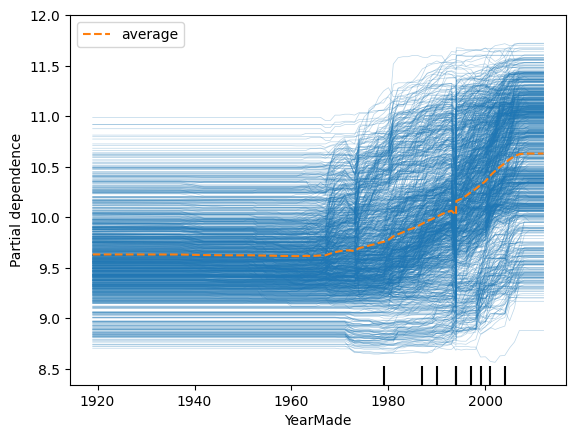

In [57]:
features = [1]
PartialDependenceDisplay.from_estimator(final_model, x_train, features, kind='both')

# Tree Interpreter

Yapılan tahminin sonucunun bu şekilde çıkmasını sağlayan etkenler neler bunları bulacağız.
- Kliması var pozitif mi etkiledi?
- Kaç yılında yapıldığı pozitif mi etkiledi?
- Pozitif etkilediyse ne kadar etkiledi?

Splitlerin tahminini ne kadar değiştirdiğine gmre senin o özelliğinin sonucu nasıl etkilediğinin sonucunu sayısal olarak almaktadır.

In [58]:
!pip install treeinterpreter

In [59]:
from treeinterpreter import treeinterpreter as ti

In [60]:
row = x_valid.values[None,0];
row

array([[False, 1995.0, False, 22112, 1288137600000000000, 51, False, 59,
        False, True, 858, 2649173, 2010, 267, 1848836, True, 71, 1,
        False, True, False, False, 9, 300, 27, False]], dtype=object)

In [61]:
prediction, bias, contributions = ti.predict(final_model, row)
# prediction : en son değişken ile alakalı tahmin
# bias : en baştaki bütün veri hakkındaki ortalama tahmin
# contributions : splitlerdeki oluşan farkları toplayıp buraya atıyoruz

In [62]:
prediction[0], bias[0]

(array([9.64867268]), 10.105190985529001)

In [63]:
contributions.shape

(1, 26)

In [64]:
idxs = np.argsort(contributions[0]) # sıralar ve indexlerini return eder
idxs

array([ 0,  4,  1,  3, 12, 15, 21, 11, 10,  5, 13, 20, 22, 23,  7, 14, 24,
        9, 25, 19, 18,  6, 17,  2,  8, 16])

In [65]:
[o for o in zip(x_valid.columns[idxs],
                x_valid.iloc[0][idxs],
                contributions[0][idxs])]

[('Enclosure_EROPS w AC', False, -0.16760361925367595),
 ('DateElapsed', 1288137600000000000, -0.14704065145310313),
 ('YearMade', 1995.0, -0.10920215212766866),
 ('ModelID', 22112, -0.09395505693624263),
 ('DateYear', 2010, -0.08244042502926804),
 ('ProductSize_nan', True, -0.07247675988789254),
 ('ProductSize_Medium', False, -0.03223319212631834),
 ('SalesID', 2649173, -0.030589788628102712),
 ('fiModelDesc', 858, -0.024332086116827422),
 ('fiProductClassDesc', 51, -0.022603606144631038),
 ('fiBaseModel', 267, -0.01753108368328631),
 ('ProductSize_Large / Medium', False, -0.009069054232304419),
 ('state', 9, -0.005202135341679614),
 ('DateDayofyear', 300, -0.004896411800383402),
 ('fiSecondaryDesc', 59, -0.002137101717312317),
 ('MachineID', 1848836, -0.0012329563399194204),
 ('DateDay', 27, 0.0030439738220793696),
 ('Coupler_System_nan', True, 0.013185852410844403),
 ('ProductSize_Compact', False, 0.01617050989644691),
 ('Grouser_Tracks_nan', True, 0.018566425344740088),
 ('Drive_Sy

In [66]:
[o for o in zip(x_train.columns[idxs],
                x_train.iloc[0][idxs],
                contributions[0][idxs])]

# Her feature'ın tahminimize olan katkısını sayısal olarak elde ettik.

[('Enclosure_EROPS w AC', True, -0.16760361925367595),
 ('DateElapsed', 1163635200000000000, -0.14704065145310313),
 ('YearMade', 2004.0, -0.10920215212766866),
 ('ModelID', 3157, -0.09395505693624263),
 ('DateYear', 2006, -0.08244042502926804),
 ('ProductSize_nan', True, -0.07247675988789254),
 ('ProductSize_Medium', False, -0.03223319212631834),
 ('SalesID', 1139246, -0.030589788628102712),
 ('fiModelDesc', 963, -0.024332086116827422),
 ('fiProductClassDesc', 59, -0.022603606144631038),
 ('fiBaseModel', 298, -0.01753108368328631),
 ('ProductSize_Large / Medium', False, -0.009069054232304419),
 ('state', 1, -0.005202135341679614),
 ('DateDayofyear', 320, -0.004896411800383402),
 ('fiSecondaryDesc', 43, -0.002137101717312317),
 ('MachineID', 999089, -0.0012329563399194204),
 ('DateDay', 16, 0.0030439738220793696),
 ('Coupler_System_nan', True, 0.013185852410844403),
 ('ProductSize_Compact', False, 0.01617050989644691),
 ('Grouser_Tracks_nan', True, 0.018566425344740088),
 ('Drive_Syste

# Dealing with Extrapolation

We are adding new colmn to say us if that is coming from validation set or not.

In [67]:
df_ext = df.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_train] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [70]:
m = RandomForestClassifier(n_estimators=40,
                           min_samples_leaf=3,
                           max_features=0.5,
                           n_jobs=-1,
                           oob_score=True)
%time m.fit(x, y);
m.oob_score_

CPU times: user 59.6 s, sys: 653 ms, total: 1min
Wall time: 18.1 s


0.9999975769206538

Bu modelin özellik önemini bulursak, bu bize doğrulamayı eğitimden ayıran önemli parametreleri söyleyecektir. SalesID, doğrulama setinde belirlenmesinde önemlidir, bu nedenle rastgele olamaz, zamanla ilgilidir. Sadece sıraya bakmayın, değerlerine de bakın. İlk 3-4 diğerlerinden daha önemlidir.

Train ve valid veri seti için extrapolation problemi var diyebiliriz. Çünkü verinin trainmi validmi olduğunu %99 oranında tahmin edebildik. Demekki random olarak ayrılmamışlar. Baştan %80'e kadar train %80'den 100'e kadar valid gibi bir şekilde ayrılmıştır sonucuna varıyoruz.

In [71]:
feature_importance_for_extrapolation = rf_feat_importance(m, x);

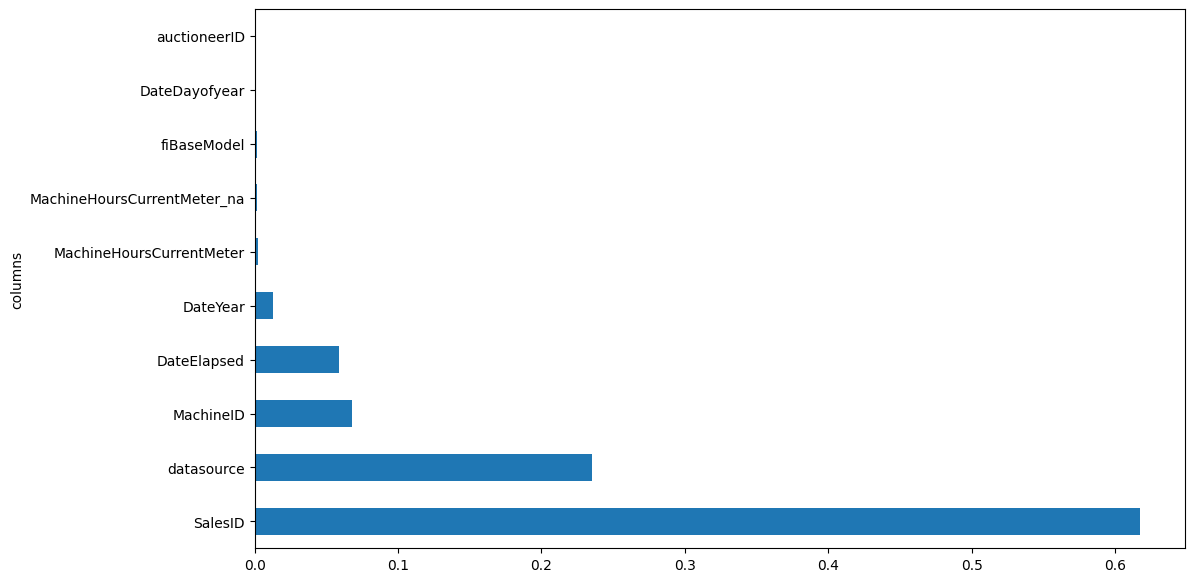

In [72]:
plot_feature_importance(feature_importance_for_extrapolation[:10]);

In [73]:
m = RandomForestClassifier(n_estimators=40,
                           min_samples_leaf=3,
                           max_features=0.5,
                           n_jobs=-1,
                           oob_score=True)
%time m.fit(x.drop(['SalesID', 'datasource', 'DateElapsed', 'MachineID', 'DateYear'], axis=1), y);
m.oob_score_

CPU times: user 4min 10s, sys: 473 ms, total: 4min 10s
Wall time: 1min 7s


0.9689918536072383

Extrapolation soruna çözüm olarak is_valid'i 1 yapan değerleri train veri setinden çıkarmak istediğimiz gibi bir sonuç vermedi. İşin doğası gereği hep gelecek veriler geleceği için random olarak train ve valid setini seçmek çok doğru olmayacaktır fakat denenebilir.

# Test

In [74]:
%time final_model.fit(x_train, y_train)
print_score(final_model, x_train, y_train, x_valid, y_valid)

CPU times: user 2min, sys: 374 ms, total: 2min 1s
Wall time: 32.9 s
RMSE of train set 0.1258783575051254
RMSE of valid set 0.2520581409311368
R^2 of train set 0.9667658521533085
R^2 of valid set 0.8822741249926159
OOB Score : 0.9076408127269843
--------------------


In [75]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 1834 non-null   object 
 8   saledate                  12457 non-null  object 
 9   fiModelDesc               12457 non-null  object 
 10  fiBaseModel               12457 non-null  object 
 11  fiSecondaryDesc           8482 non-null   object 
 12  fiModelSeries             2006 non-null   object 
 13  fiModelDescriptor         3024 non-null   object 
 14  Produc

## Read Data

In [76]:
df = test_df.copy()

## Fill Wrong YearMade

In [77]:
print('before : ', df.loc[df['YearMade'] < 1900, 'YearMade'].count())

df.loc[df['YearMade'] < 1900, 'YearMade'] = df.loc[df['YearMade'] > 1900]['YearMade'].mean()

print('after : ', df.loc[df['YearMade'] < 1900, 'YearMade'].count())

before :  1637
after :  0


## Datetime to Numeric

In [78]:
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')

In [79]:
add_datepart(df, 'saledate')

DateYear created.
DateMonth created.
DateWeek created.
DateDay created.
DateDayofweek created.
DateDayofyear created.
DateIs_month_end created.
DateIs_month_start created.
DateIs_quarter_end created.
DateIs_quarter_start created.
DateIs_year_end created.
DateIs_year_start created.
saledate deleted.
Datepart done!


## proc_df

In [80]:
df['SalePrice'] = 0

In [81]:
raw_train, raw_y, nas = proc_df(df, 'SalePrice', max_cat=7)

In [82]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 169 entries, SalesID to Steering_Controls_nan
dtypes: UInt32(1), bool(143), float64(2), int16(2), int32(5), int64(6), int8(10)
memory usage: 2.9 MB


## Feature Importance

In [83]:
df_keep = raw_train[keep_columns].copy()

In [84]:
df_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Enclosure_EROPS w AC                 12457 non-null  bool   
 1   YearMade                             12457 non-null  float64
 2   ProductGroup_SSL                     12457 non-null  bool   
 3   ModelID                              12457 non-null  int64  
 4   DateElapsed                          12457 non-null  int64  
 5   fiProductClassDesc                   12457 non-null  int8   
 6   ProductGroupDesc_Skid Steer Loaders  12457 non-null  bool   
 7   fiSecondaryDesc                      12457 non-null  int8   
 8   ProductSize_Mini                     12457 non-null  bool   
 9   Coupler_System_nan                   12457 non-null  bool   
 10  fiModelDesc                          12457 non-null  int16  
 11  SalesID                     

## Predict

In [85]:
y_pred = final_model.predict(df_keep)

In [86]:
df_pred = pd.DataFrame()
df_pred['SalesID'] = df['SalesID']
df_pred['SalePrice'] = y_pred
df_pred

,SalesID,SalePrice
0,1227829,9.471684
1,1227844,9.962529
2,1227847,10.811683
3,1227848,10.654983
4,1227863,10.485538
...,...,...
12452,6643171,11.215239
12453,6643173,9.328140
12454,6643184,9.342522
12455,6643186,9.669720


In [87]:
# df_pred.to_csv('bulldozer_pred.csv', index=False)
df_pred.to_csv('/kaggle/working/bulldozer_pred.csv', index=False)

In [88]:
random_forest_benchmark_test = pd.read_csv(r'/kaggle/input/bluebook-for-bulldozers/random_forest_benchmark_test.csv')

## RMSLE = 0.3701

In [96]:
random_forest_benchmark_test['SalePrice_log'] = np.log(random_forest_benchmark_test.SalePrice)
print(random_forest_benchmark_test['SalePrice_log'])

0         9.520029
1        10.389918
2        10.792613
3        11.472936
4        10.219757
           ...    
12452    10.986648
12453     9.226706
12454     9.316950
12455     9.526610
12456    10.268478
Name: SalePrice_log, Length: 12457, dtype: float64


In [98]:
from sklearn.metrics import mean_squared_error

In [100]:
np.sqrt(mean_squared_error(random_forest_benchmark_test.SalePrice_log, y_pred))

0.37016451703661557